# Iterative Null Space projection

A base implementation using the debias function from https://github.com/shauli-ravfogel/nullspace_projection/tree/master/src. 

Original paper: Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection, S.Ravfogel et al, 2019. 

Further experiments are outlined in: Study on Iterative Nullspace Projection Debiasing of Multiple Attributes of Word Embeddings, X.Zhang, 2022.
 
Given a set of word embeddings $X = \{x_1, x_2, \ldots, x_n\}$, $x_i \in \mathbb{R}^d$, such as professions (doctor, nurse, teacher etc) and attributes $Z = \{z_1, z_2, \ldots, z_n\}$, such as instances of gender (male, female, man, woman etc), we aim to find a transformation $g$ such that $z_i$ cannot be predicted from $g(x_i)$. The first step of INLP is, if we have a classifier $c$ used to predict a persons profession based on some text, we build an auxiliary model $c'$ to predict their gender from the text.

If $c'$ is a classifier with parameters $W$ (e.g. the weights in a deep learning model), we want a projection matrix $P$ such that $W(Pz)=0$ for all $z$, rendering the paramters $W$ useless on $Z$. 

Additional classifiers $W'$ are then trained until no linear information regading $Z$ remains in $X$. $P$ is constructed using nullspace projection, detailed implementation can be found in the original paper. In other words, we train our auxiliary model $c'$ until it predicts the protected attribute from the input text no better than randomly guessing, i.e. $\leq50 \%$ accuracy. The projection matrix is then applied to the embeddings used to train the original model with the hope that the dependency of the sensitive attribute with respect to the output is removed.

The relationship between $W$ and an input $x$ is that $x$ is projected onto the sub-space of the rows of $W$ and is classified by taking the dot product between $W$ and the components of its rows. Therefore if we zero the components of $x$ in the direction of $W's$ rowspace, we remove the information within $W$ used to make a predcition based on $x$, i.e. the ability to make a prediction based on a sensitive attribute in the set $X$. 

Algebraically this is equaivalent to projecting $x$ onto the nullspace of $W$, $N(W)$:
$$
N(W) = \{ x \mid Wx = 0 \}
$$

In summary, for a task where we are predicting a feature $x_i \in X$ from a text sample containing sensitive features $z_i \in Z$, using a classifier $c$, e.g. a person's profession from text containing information about said person, we make a new classifier $c'$ to predict the person's gender (or any other sensitive attribute we want to protect) from the text, and use this to create a projection matrix which is applied to the original text data embeddings, removing the classifiers ability to use gender information when making a prediction.

In [29]:
import classifier
import old_debias
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.svm import LinearSVC, SVC
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns

#import warnings
#warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload

C:\Users\tchoudhury\AppData\Local\Temp\ipykernel_29908\4061483943.py:25: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing Universal Sentence Encoder

We use Universal Sentence Encoder (USE) to generate word embeddings. It is a model which takes a string of text as input and returns a vector containing the word embeddings for the input. These word embeddings will be used to train a classifier to predict the risk based on the prompt, and later for the generation of the projection matrix. 

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


Loading augmented German Credit Scoring dataset

In [3]:
# Load dataset

url='https://drive.google.com/file/d/1N7z7Nn4IuQjZSv1eqLh32HKrKKaLrsoQ/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df=pd.read_csv(dwn_url)
df

,Prompt,Sex,Risk
0,"Using the following characteristics, assess wh...",male,good
1,"Using the following characteristics, assess wh...",female,bad
2,"Using the following characteristics, assess wh...",male,good
3,"Using the following characteristics, assess wh...",male,good
4,"Using the following characteristics, assess wh...",male,bad
...,...,...,...
995,"Using the following characteristics, assess wh...",female,good
996,"Using the following characteristics, assess wh...",male,good
997,"Using the following characteristics, assess wh...",male,good
998,"Using the following characteristics, assess wh...",male,bad


Get embeddings for prompts using Universal Sentence Encoder. This transforms the dataset into a 1000x512 tensor, 1000 inputs each 512 vectors long.

In [137]:
# List of text instances to be embedded
prompts = df['Prompt'].tolist()
genders = df['Sex'].tolist()
risk = df['Risk'].tolist()
# Embed prompts using USE
prompt_embeddings = embed(prompts)
print(tf.shape(prompt_embeddings))


tf.Tensor([1000  512], shape=(2,), dtype=int32)


Next we encode the categorical features, i.e. the risk and also gender which is required for the generation of the projection matrix.

In [25]:
# Convert tensor into NumPy array
prompt_embeddings_np = prompt_embeddings.numpy()
# Encode risk and gender labels
le = LabelEncoder()
risk_encoded = le.fit_transform(risk)
gender_encoded = le.fit_transform(genders)


Train a classifier to predict credit risk based on embedded prompts. The inputs, X_train are the embedded prompts and the outputs, y_train are the encoded risk scores. We use these to train a linear SVM model which achieves a ~70% accuracy score.

In [24]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(prompt_embeddings_np, risk_encoded, test_size=0.2)

# Initialise classifier
clf = SVC(kernel='linear')

# Fit classifier
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.7

The first step of debiasing is to obtain a projection matrix by iteratively training another classifier to predict the gender based on the prompts. X_train_gender is a dataset containing the embedded prompts (the same as used before), y_train_gender contains the encoded gender outputs (male/female)

In [26]:
# Split dataset
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(prompt_embeddings_np, gender_encoded, test_size = 0.2, shuffle = False, stratify = None)

In [27]:
# Get projection matrix
def get_projection_matrix(num_clfs, X_train, y_train, X_test, y_test, y_train_main, y_test_main, dim=300):

    is_autoregressive = True
    reg = "l2"
    min_acc = 0.
    noise = False
    random_subset = False
    regression = False
    
    clf = SGDClassifier
    params = {'warm_start': True, 'loss': 'log_loss', 'n_jobs': 64, 'max_iter': 100, 'random_state': 0}

    P = old_debias.get_debiasing_projection(clf, params, num_clfs, dim, is_autoregressive,
                                           min_acc, X_train, y_train, X_test, y_test,
                                           by_class=True, y_train_main=y_train_main, y_test_main=y_test_main)
    return P



num_clfs = 40
y_test_gender = np.array(y_test_gender)
y_train_gender = np.array(y_train_gender)
y_test = np.array(y_test)
y_train = np.array(y_train)

n_examples = 1000

In [39]:
P = get_projection_matrix(100, X_train_gender[:n_examples],
                          y_train_gender[:n_examples], X_test_gender[:n_examples], y_test_gender[:n_examples],
                             y_train[:n_examples], y_test[:n_examples], dim = 512)

iteration: 99, accuracy: 0.725: 100%|██████████| 100/100 [00:05<00:00, 18.68it/s]


Once the projection matrix $P$ is obtained, we apply it to the embeddings used to train our first model.

In [32]:
# Apply projection matrix to embeddings
debiased_train = X_train_gender.dot(P)
debiased_test = X_test_gender.dot(P)

Accuracy score for model predicting gender based on prompts. Expected 100% accuracy

In [34]:
params = {'warm_start': True, 'loss': 'log_loss', 'n_jobs': 64, 'max_iter': 75, 'random_state': 0}
temp = SGDClassifier(**params)

temp.fit(X_train_gender[:n_examples], y_train_gender[:n_examples])
temp.score(X_test_gender, y_test_gender)

1.0

Accuracy score for model predicting gender based on debiased prompts

In [35]:
params = {'warm_start': True, 'loss': 'log_loss', 'n_jobs': 64, 'max_iter': 75, 'random_state': 0}
temp = SGDClassifier(**params)

temp.fit(debiased_train[:n_examples], y_train_gender[:n_examples])
temp.score(debiased_test, y_test_gender)

0.725

Accuracy score for model predicting risk based on prompts (already done above)

In [36]:
params = {'warm_start': True, 'loss': 'log_loss', 'n_jobs': 64, 'max_iter': 75, 'random_state': 0}
temp = SGDClassifier(**params)

temp.fit(X_train_gender[:n_examples], y_train[:n_examples])
temp.score(X_test_gender, y_test)

0.7

Accuracy score for model predicting risk based on debiased prompts

In [37]:
params = {'warm_start': True, 'loss': 'log_loss', 'n_jobs': 64, 'max_iter': 75, 'random_state': 0}
temp = SGDClassifier(**params)

temp.fit(debiased_train[:n_examples], y_train[:n_examples])
temp.score(debiased_test, y_test)

0.7

Visualising the matrices. The figure on the left shows a colourmap of the training data, the embedded prompts. The image on the left shows the embeddings with the projection matrix applied

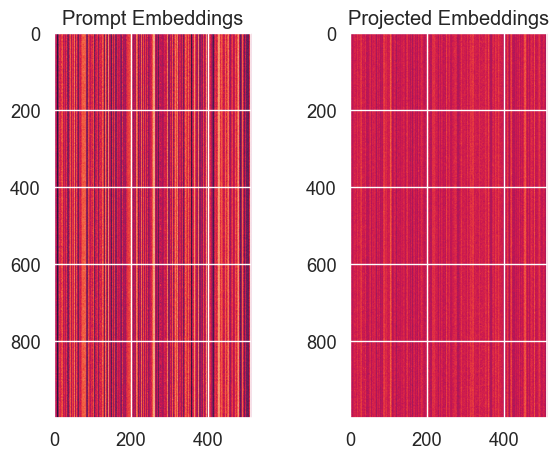

In [134]:
# Subplots comparing embeddings before and after projection matrix is applied
fig, ax = plt.subplots(1, 2, figsize=(7, 5))

ax[0].imshow(prompt_embeddings_np)
ax[0].set_title('Prompt Embeddings')

projected_embeddings = np.dot(prompt_embeddings_np,P)
ax[1].imshow(projected_embeddings)
ax[1].set_title('Projected Embeddings')

plt.show()

The final step is to train a new classifier using the debiased dataset, to predict the risk based on the debiased prompts.

In [139]:
# Split dataset
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(projected_embeddings, risk_encoded, test_size=0.2)

# Initialise classifier
clf_p = SVC(kernel='linear')

# Fit classifier
clf_p.fit(X_train_p, y_train_p)

# Predictions
y_pred_p = clf.predict(X_test)
accuracy_score(y_test_p, y_pred_p)

0.665

Plot semantic similarity between prompts before and after nullspace projection

In [119]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      #xticklabels=labels,
      #yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity([1,2], message_embeddings_, 90)

In [142]:
# Semantic similarity between pair of sentences before projection

messages_before = [df['Prompt'][1], df['Prompt'][2]]

df['Prompt'][1]

'Using the following characteristics, assess whether or not the person is a good or bad credit risk. The person is a 22 year old female. Their ethnicity is hispanic. Their marital status is married. Their job category is 2. They own their house. They have a moderate amount in their checking account. They have little savings. They are asking for a credit amount of £5951 over a period of 48 months for the purpose of radio/TV. Answer only using "good" or "bad".'

In [141]:
df['Prompt'][2]

'Using the following characteristics, assess whether or not the person is a good or bad credit risk. The person is a 49 year old male. Their ethnicity is black. Their marital status is single. Their job category is 1. They own their house. They have no checking account or nothing in their checking account. They have little savings. They are asking for a credit amount of £2096 over a period of 12 months for the purpose of education. Answer only using "good" or "bad".'

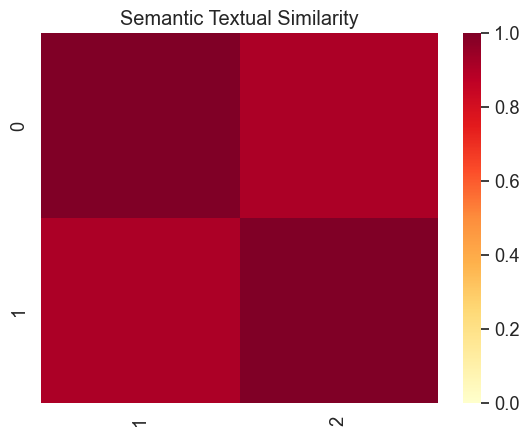

In [89]:
run_and_plot(messages_before)

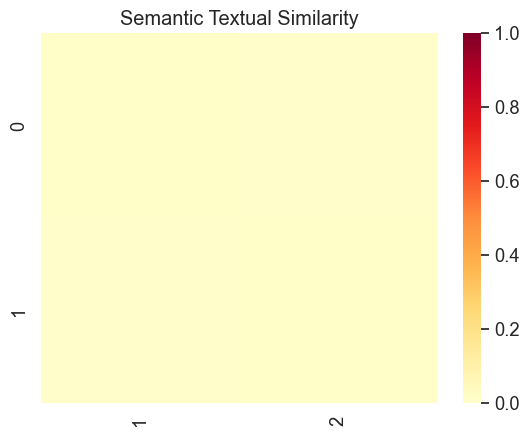

In [91]:
plot_similarity([1,2],[projected_embeddings[1], projected_embeddings[2]], 90)